In [ ]:
# Copyright (c) 2025, ETH Zurich

In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.stats as stats
import scipy.ndimage
from tqdm import tqdm
import spekpy as spk
import h5py

from scipy import interpolate

In [ ]:
rave_sim_dir = Path('../rave-sim').resolve()
simulations_dir = Path('<PATH_TO_STORE_SIMULATIONS>')
scratch_dir = simulations_dir


sys.path.insert(0, str(rave_sim_dir / "nist_lookup"))
from nist_lookup.xraydb_plugin import xray_delta_beta

In [3]:
sys.path.insert(0, str(rave_sim_dir / "big-wave"))
import multisim
import config
import util
import propagation


In [ ]:
def calculate_G1_height(eng):
    # constants
    h = 6.62607004 * 10**(-34) # planck constant in mˆ2 kg / s
    c_0 = 299792458 # speed of light in m / s
    eV_to_joule = 1.602176634*10**(-19)
    N_A = 6.02214086 * 10**23 #[1/mol]
    
    lambda_ = h * c_0 / (eng*eV_to_joule)
    delta_diff = xray_delta_beta('Au', 19.32, eng)[0] -  xray_delta_beta('Si', 2.34, eng)[0]
    height = np.pi  * lambda_ / (2*np.pi * delta_diff)

    return height


def signal_retrieval_least_squares(data, period=None, axis=-1):
    if axis != -1:
        data = np.moveaxis(data, axis, -1)

    nsteps = data.shape[-1]

    if period is None:
        period = nsteps

    phi = np.linspace(0, 2 * np.pi * nsteps / (period), nsteps, endpoint=False)
    M = np.c_[np.sin(phi), np.cos(phi), np.ones(nsteps)]
    res, chi2, _rank, _sing_vals = np.linalg.lstsq(M, data.reshape((-1, nsteps)).T, rcond=-1)

    res = res.T.reshape((*data.shape[:-1], -1))

    dabs = res[...,2]
    dphase = -np.arctan2(res[...,0], res[...,1])
    dvis = np.sqrt(res[...,0]**2 + res[...,1]**2) / dabs

    # normalization to the total number of counts
    dabs *= nsteps

    return dabs, dphase, dvis, np.nanmean(chi2)


def calculate_pixel_intensity(x, fringe, pxEdges, statistics = 'sum'):
    fringeStats = stats.binned_statistic(x, fringe, bins=pxEdges, statistic = statistics)
    return fringeStats.statistic

def perform_binned_signal_retrieval(x, wf, pxSize, nrSteps, plot_curve = True):
    leftSide = np.arange(0-pxSize/2, np.min(x), -pxSize)
    rightSide = np.arange(0 + pxSize/2, np.max(x), pxSize)
    pxEdges = np.concatenate([np.flip(leftSide), rightSide])
    int_px = []
    for i in range(nrSteps):
        int_px.append(calculate_pixel_intensity(x, wf[i,:], pxEdges))
    int_px = np.asarray(int_px)

    trans, phase, vis, _ = signal_retrieval_least_squares(int_px, period = nrSteps, axis = 0)
    if plot_curve:
        plot_curves(trans, phase, vis, pxEdges)
    return int_px, trans, phase, vis, pxEdges

def plot_curves(trans, phase, vis, pxEdges):

    fig, axs = plt.subplots(figsize=(15,6), sharex = True, nrows = 1, ncols = 2)
    axs[0].plot(pxEdges[1:], trans, label = 'Transmission')
    axs[0].set_title('Transmission')
    axs[1].plot(pxEdges[1:], vis, label = 'Visibility')
    axs[1].set_title('Visibility')

def perform_binning(x, wf, pxSize):
    leftSide = np.arange(0-pxSize/2, np.min(x), -pxSize)
    rightSide = np.arange(0 + pxSize/2, np.max(x), pxSize)
    pxEdges = np.concatenate([np.flip(leftSide), rightSide])
    int_px = calculate_pixel_intensity(x, wf, pxEdges, statistics = 'mean')
    return int_px

    
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def calculate_SNR(wavefronts, detector_x, phase_steps):
    summed_wf = np.zeros_like(wavefronts[0][0])
        
    for point in wavefronts:
        wf, x_point, eng = point
        
        summed_wf += wf

    return summed_wf

def get_subdict(dict_, idx):
    sub_dict = {}
    for key in dict_.keys():
        sub_dict[key] = dict_[key][idx]
    return sub_dict


In [5]:
# constants
h = 6.62607004 * 10**(-34) # planck constant in mˆ2 kg / s
c_0 = 299792458 # speed of light in m / s
eV_to_joule = 1.602176634*10**(-19)
N_A = 6.02214086 * 10**23 #[1/mol]
E_des = 46000

lambda_ = h * c_0 / (E_des*eV_to_joule)
p2 = 4.2*10**(-6)
p0 = p1 = p2

Dn_3 = 3*p2**2/(2*lambda_) / 2
print(Dn_3)

z_g0 = 0.218
z_g1 = z_g0 + Dn_3
z_g2 = z_g0 + 2*Dn_3
z_detector = z_g2 + 0.01

h0 = h2 = 180e-6
h1 = 59e-6

print("Z0: ", z_g0)
print("Z1: ", z_g1)
print("Z2: ", z_g2)
print("Z Detector: ", z_detector)

print(Dn_3)

0.49085288108789216
Z0:  0.218
Z1:  0.7088528810878921
Z2:  1.1997057621757843
Z Detector:  1.2097057621757843
0.49085288108789216


In [6]:
N = 2**26
max_energy = 70000
dx = propagation.max_dx(z_g0, 10e-6, N, propagation.convert_energy_wavelength(max_energy))

In [ ]:
s = spk.Spek(kvp=70, dk = 0.1, th = 10) # Create a spectrum

s.filter('Be', 0.15) # Create a spectrum
k, f = s.get_spectrum(edges=True) # Get the spectrum

energyRange = [4000, 70000]
dE = 100
filtering = 0.000

energies = np.arange(5, 70+0.1, 0.1)*1e3


tube_spectrum_txt = interpolate.interp1d(k*1e3, f, fill_value = 'extrapolate')
spec_txt = tube_spectrum_txt(energies)

with h5py.File('../spectra/spectrum_70_spekpy_unfiltered.h5', 'w') as h5:
    h5.create_dataset('pdf', data =  spec_txt/ np.sum(spec_txt))
    h5.create_dataset('energy', data = energies) 

path_to_spectrum = os.path.abspath('../spectra/spectrum_70_spekpy_unfiltered.h5')

(0.0, 100000000.0)

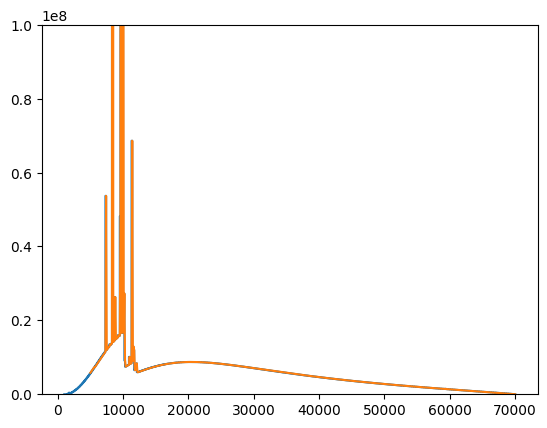

In [8]:
plt.plot(k*1e3, f)
plt.plot(energies, spec_txt)
plt.ylim(0, 0.1*1e9)

In [ ]:
config_dict = {
        "sim_params": {
            "N": N,
            "dx": dx,
            "z_detector": z_g2 + 500e-6,
            "detector_size": 0.004,
            "detector_pixel_size_x": 1e-7,
            "detector_pixel_size_y": 1.0,
            "chunk_size": 256 * 1024 * 1024 // 16,  # use 256MB chunks
        },
        "use_disk_vector": False,
        "save_final_u_vectors": False,
        "dtype": "c8",
        "multisource": {
            "type": "points",
            "energy_range": [11000, 70000],
            "x_range": [-10e-6, 10e-6],
            "z": 0.0,
            "nr_source_points": 1000,
            "seed": 1,
            "spectrum": path_to_spectrum,
        },
        "elements": [
            {
                "type": "grating",
                "pitch": p0,
                "dc": [0.5, 0.5],
                "z_start": z_g0,
                "thickness": h0,
                "nr_steps": 30,
                "x_positions": [0.0],
                "substrate_thickness": 500*1e-6 - h0,
                "mat_a": ["C5H8O2", 1.19],
                "mat_b": ["Au", 19.32],
                "mat_substrate": ["C", 2.26],
            },
            {
                "type": "grating",
                "pitch": p1,
                "dc": [0.5, 0.5],
                "z_start": z_g1,
                "thickness": h1,
                "nr_steps": 10,
                "x_positions": [0.0],
                "substrate_thickness": 200 * 1e-6 - h1,
                "mat_a": ["Si", 2.34],
                "mat_b": None,
                "mat_substrate": ["Si", 2.34],
            },
            {
                "type": "grating",
                "pitch": p2,
                "dc": [0.5, 0.5],
                "z_start": z_g2,
                "thickness": h2,
                "nr_steps": 30,
                "x_positions": (np.arange(5) * p2/5).tolist(),
                "substrate_thickness": 500*1e-6 - h2,
                "mat_a": ["C5H8O2", 1.19],
                "mat_b": ["Au", 19.32],
                "mat_substrate": ["C", 2.26],
            },
        ],
}

sim_path = multisim.setup_simulation(config_dict, Path("."), simulations_dir)

2024-03-18 20:24:33,216 INFO: Setting up simulation
2024-03-18 20:25:30,312 INFO: Finished setting up simulation in /scratch/vieirapa/XNPIG_Data/2024/03/20240318_202528164273


In [ ]:
for i in range(1000):
    os.system(f"CUDA_VISIBLE_DEVICES=0 ../rave-sim/fast-wave/build-Release/fastwave -s {i} {sim_path}")

[2024-03-18 20:25:30.341] [info] Running simulation /scratch/vieirapa/XNPIG_Data/2024/03/20240318_202528164273/00000000
[2024-03-18 20:25:30.707] [info] Simulating optical element 1/3
[2024-03-18 20:25:31.480] [info] Elapsed time for optical element: 773.05035 ms
[2024-03-18 20:25:31.501] [info] Simulating optical element 2/3
[2024-03-18 20:25:31.773] [info] Elapsed time for optical element: 272.09506 ms
[2024-03-18 20:25:31.797] [info] Simulating optical element 3/3
[2024-03-18 20:25:32.566] [info] Elapsed time for optical element: 769.37115 ms
[2024-03-18 20:25:32.568] [info] Running phase step 2/5
[2024-03-18 20:25:32.570] [info] Simulating optical element 3/3
[2024-03-18 20:25:33.340] [info] Elapsed time for optical element: 770.784 ms
[2024-03-18 20:25:33.342] [info] Running phase step 3/5
[2024-03-18 20:25:33.344] [info] Simulating optical element 3/3
[2024-03-18 20:25:34.115] [info] Elapsed time for optical element: 771.4353 ms
[2024-03-18 20:25:34.116] [info] Running phase step